## Using RNNs to classify sentiment on IMDB data
### Modified by Darshan Patel

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import SimpleRNN
from keras.datasets import imdb
from keras import initializers

/Users/darshanpatel/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
max_features = 20000  # This is used in loading the data, picks the most common (max_features) words
maxlen = 30  # maximum length of a sequence - truncate after this
batch_size = 32

In [3]:
## Load in the data.  The function automatically tokenizes the text into distinct integers
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


In [4]:
# This pads (or truncates) the sequences so that they are of the maximum length
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 30)
x_test shape: (25000, 30)


In [5]:
x_train[123,:]  #Here's what an example sequence looks like

array([  219,   141,    35,   221,   956,    54,    13,    16,    11,
        2714,    61,   322,   423,    12,    38,    76,    59,  1803,
          72,     8, 10508,    23,     5,   967,    12,    38,    85,
          62,   358,    99], dtype=int32)

## Keras layers for (Vanilla) RNNs

In this exercise, we will not use pre-trained word vectors.  Rather we will learn an embedding as part of the Neural Network.  This is represented by the Embedding Layer below.

### Embedding Layer
`keras.layers.embeddings.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)`

- This layer maps each integer into a distinct (dense) word vector of length `output_dim`.
- Can think of this as learning a word vector embedding "on the fly" rather than using an existing mapping (like GloVe)
- The `input_dim` should be the size of the vocabulary.
- The `input_length` specifies the length of the sequences that the network expects.

### SimpleRNN Layer
`keras.layers.recurrent.SimpleRNN(units, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)`

- This is the basic RNN, where the output is also fed back as the "hidden state" to the next iteration.
- The parameter `units` gives the dimensionality of the output (and therefore the hidden state).  Note that typically there will be another layer after the RNN mapping the (RNN) output to the network output.  So we should think of this value as the desired dimensionality of the hidden state and not necessarily the desired output of the network.
- Recall that there are two sets of weights, one for the "recurrent" phase and the other for the "kernel" phase.  These can be configured separately in terms of their initialization, regularization, etc.






In [6]:
## Let's build a RNN

rnn_hidden_dim = 5
word_embedding_dim = 50
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, word_embedding_dim))  #This layer takes each integer in the sequence and embeds it in a 50-dimensional vector
model_rnn.add(SimpleRNN(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=x_train.shape[1:]))

model_rnn.add(Dense(1, activation='sigmoid'))

In [7]:
## Note that most of the parameters come from the embedding layer
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 5)                 280       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 1,000,286
Trainable params: 1,000,286
Non-trainable params: 0
_________________________________________________________________


In [8]:
rmsprop = keras.optimizers.RMSprop(lr = .0001)

model_rnn.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [10]:
history = model_rnn.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 9s 376us/step - loss: 0.4718 - acc: 0.7785 - val_loss: 0.4968 - val_acc: 0.7548
Epoch 2/10
25000/25000 [==============================] - 10s 401us/step - loss: 0.4369 - acc: 0.8012 - val_loss: 0.4738 - val_acc: 0.7680
Epoch 3/10
25000/25000 [==============================] - 10s 402us/step - loss: 0.4117 - acc: 0.8132 - val_loss: 0.4597 - val_acc: 0.7775
Epoch 4/10
25000/25000 [==============================] - 10s 384us/step - loss: 0.3927 - acc: 0.8232 - val_loss: 0.4541 - val_acc: 0.7794
Epoch 5/10
25000/25000 [==============================] - 10s 381us/step - loss: 0.3790 - acc: 0.8303 - val_loss: 0.4487 - val_acc: 0.7857
Epoch 6/10
25000/25000 [==============================] - 9s 377us/step - loss: 0.3688 - acc: 0.8351 - val_loss: 0.4446 - val_acc: 0.7891
Epoch 7/10
25000/25000 [==============================] - 10s 382us/step - loss: 0.3613 - acc: 0.8414 - val_loss: 0.44

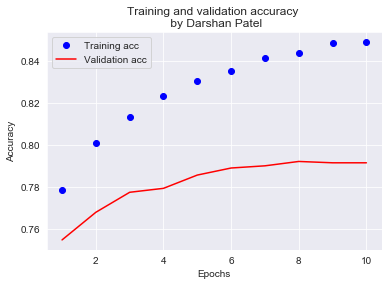

In [21]:
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy \n by Darshan Patel')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [11]:
score, acc = model_rnn.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 1s 40us/step
Test score: 0.4483137394809723
Test accuracy: 0.79156


### Exercise

In [12]:
max_features = 20000  # This is used in loading the data, picks the most common (max_features) words
maxlen = 5 # maximum length of a sequence  

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [13]:
rnn_hidden_dim = 5
word_embedding_dim = 50
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, word_embedding_dim))  #This layer takes each integer in the sequence
model_rnn.add(SimpleRNN(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=x_train.shape[1:]))

model_rnn.add(Dense(1, activation='sigmoid'))

In [14]:
rmsprop = keras.optimizers.RMSprop(lr = .0001)

model_rnn.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [15]:
model_rnn.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 6s 238us/step - loss: 0.6894 - acc: 0.5638 - val_loss: 0.6808 - val_acc: 0.6034
Epoch 2/10
25000/25000 [==============================] - 6s 234us/step - loss: 0.6626 - acc: 0.6351 - val_loss: 0.6482 - val_acc: 0.6402
Epoch 3/10
25000/25000 [==============================] - 6s 246us/step - loss: 0.6254 - acc: 0.6700 - val_loss: 0.6215 - val_acc: 0.6580
Epoch 4/10
25000/25000 [==============================] - 6s 234us/step - loss: 0.5957 - acc: 0.6917 - val_loss: 0.6046 - val_acc: 0.6664
Epoch 5/10
25000/25000 [==============================] - 6s 231us/step - loss: 0.5736 - acc: 0.7039 - val_loss: 0.5958 - val_acc: 0.6713
Epoch 6/10
25000/25000 [==============================] - 6s 226us/step - loss: 0.5580 - acc: 0.7142 - val_loss: 0.5909 - val_acc: 0.6741
Epoch 7/10
25000/25000 [==============================] - 6s 233us/step - loss: 0.5472 - acc: 0.7221 - val_loss: 0.5882 - 

In [16]:
score, acc = model_rnn.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 0s 14us/step
Test score: 0.5850617629241943
Test accuracy: 0.68168
